In [18]:
#importing libraries
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,Conv2D,BatchNormalization,Activation,Dropout,MaxPooling2D,GlobalMaxPooling2D
from keras.applications import VGG19

In [2]:
#version check 
print('Numpy --{}'.format(np.__version__))
print('Pandas --{}'.format(pd.__version__))
print('OpenCV --{}'.format(cv2.__version__))
print('Tensorflow --{}'.format(tf.__version__))
print('Keras --{}'.format(keras.__version__))

Numpy --1.18.5
Pandas --1.1.2
OpenCV --4.1.2
Tensorflow --2.3.0
Keras --2.4.0


In [3]:
#load google drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip  '/content/drive/My Drive/Git repo/Cat vs Dog Classification/test1.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/test1/55.jpg   
  inflating: /content/test1/550.jpg  
  inflating: /content/test1/5500.jpg  
  inflating: /content/test1/5501.jpg  
  inflating: /content/test1/5502.jpg  
  inflating: /content/test1/5503.jpg  
  inflating: /content/test1/5504.jpg  
  inflating: /content/test1/5505.jpg  
  inflating: /content/test1/5506.jpg  
  inflating: /content/test1/5507.jpg  
  inflating: /content/test1/5508.jpg  
  inflating: /content/test1/5509.jpg  
  inflating: /content/test1/551.jpg  
  inflating: /content/test1/5510.jpg  
  inflating: /content/test1/5511.jpg  
  inflating: /content/test1/5512.jpg  
  inflating: /content/test1/5513.jpg  
  inflating: /content/test1/5514.jpg  
  inflating: /content/test1/5515.jpg  
  inflating: /content/test1/5516.jpg  
  inflating: /content/test1/5517.jpg  
  inflating: /content/test1/5518.jpg  
  inflating: /content/test1/5519.jpg  
  inflating: /content/test1/552.jpg  
  inflating: /con

In [5]:
!unzip '/content/drive/My Drive/Git repo/Cat vs Dog Classification/Model Data.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/Model Data/validation/cat/cat.10002.jpg  
  inflating: /content/Model Data/validation/cat/cat.10003.jpg  
  inflating: /content/Model Data/validation/cat/cat.10004.jpg  
  inflating: /content/Model Data/validation/cat/cat.10005.jpg  
  inflating: /content/Model Data/validation/cat/cat.10006.jpg  
  inflating: /content/Model Data/validation/cat/cat.10007.jpg  
  inflating: /content/Model Data/validation/cat/cat.10008.jpg  
  inflating: /content/Model Data/validation/cat/cat.10009.jpg  
  inflating: /content/Model Data/validation/cat/cat.10010.jpg  
  inflating: /content/Model Data/validation/cat/cat.10011.jpg  
  inflating: /content/Model Data/validation/cat/cat.10012.jpg  
  inflating: /content/Model Data/validation/cat/cat.10013.jpg  
  inflating: /content/Model Data/validation/cat/cat.10014.jpg  
  inflating: /content/Model Data/validation/cat/cat.10015.jpg  
  inflating: /content/Model Data/validation/cat/cat.1

In [19]:
#load Xception model from keras
base_model=VGG19(include_top=False,weights='imagenet',input_shape=(150,150,3))

80142336/80134624 [==============================] - 2s 0us/step


In [20]:
#set layers trainable to False
base_model.trainable = False

In [21]:
#get the summary
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [31]:
#input of (150,150,3)
inputs = keras.Input(shape=(150, 150, 3))
normalize_inuts=tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#building model on top of Xception
x = base_model(normalize_inuts, training=False)
x = GlobalMaxPooling2D()(x)
x= Dropout(0.2)(x)

#sigmoid prediction layer
out = Dense(1, activation='sigmoid')(x)
#create model
model = Model(inputs, out)

In [32]:
#model + top smmary
model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
________________________________________

In [33]:
#model compilation
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[keras.metrics.BinaryAccuracy()])

In [34]:
#image augmentation parameters
train_datagen=ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [35]:
#train folder path
train_dir='/content/Model Data/train/'

#load train images in train_generator
train_generator=train_datagen.flow_from_directory(
            train_dir,
            shuffle=True,
            target_size=(150,150),
            batch_size=32,
            class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [36]:
#normalize validation data
validation_datagen=ImageDataGenerator()
#validation folder path
validation_dir='/content/Model Data/validation/'
#load validation images in validation_generator
validation_generator=validation_datagen.flow_from_directory(
            validation_dir,
            shuffle=False,
            target_size=(150,150),
            batch_size=32,
            class_mode='binary'
)

Found 5000 images belonging to 2 classes.


In [37]:
#early stopping callback monitoring val_loss
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,min_delta=0.001)

In [38]:
#start timer
start=time.time()

history=model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(20000/32)),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(5000/32)),
        callbacks=[earlystopping])
#end timer
end=time.time()
print('Time taken {} seconds'.format(round(end-start)))

Epoch 1/20
625/625 [==============================] - 110s 175ms/step - loss: 0.5599 - binary_accuracy: 0.7052 - val_loss: 0.3803 - val_binary_accuracy: 0.8320
Epoch 2/20
625/625 [==============================] - 108s 173ms/step - loss: 0.4641 - binary_accuracy: 0.7749 - val_loss: 0.3444 - val_binary_accuracy: 0.8512
Epoch 3/20
625/625 [==============================] - 106s 169ms/step - loss: 0.4475 - binary_accuracy: 0.7851 - val_loss: 0.3283 - val_binary_accuracy: 0.8576
Epoch 4/20
625/625 [==============================] - 108s 172ms/step - loss: 0.4425 - binary_accuracy: 0.7887 - val_loss: 0.3228 - val_binary_accuracy: 0.8582
Epoch 5/20
625/625 [==============================] - 109s 174ms/step - loss: 0.4369 - binary_accuracy: 0.7901 - val_loss: 0.3206 - val_binary_accuracy: 0.8592
Epoch 6/20
625/625 [==============================] - 106s 170ms/step - loss: 0.4350 - binary_accuracy: 0.7934 - val_loss: 0.3185 - val_binary_accuracy: 0.8630
Epoch 7/20
625/625 [====================

In [39]:
#after initial training

#set base_model layer trainable as True
base_model.trainable = True

In [40]:
#recompile model
#reduce model learning rate
model.compile(loss='binary_crossentropy',
            optimizer=tf.keras.optimizers.Adam(1e-5),
            metrics=[keras.metrics.BinaryAccuracy()])

In [41]:
#early stopping callback
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,min_delta=0.001)

In [42]:
#custom callback
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_binary_accuracy') is not None and logs.get('val_binary_accuracy')>0.99):
            print('Got desired accuracy, stop training.')
            self.model.stop_training=True

In [43]:
callback=mycallback()

In [44]:
#start timer
start=time.time()

history=model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(20000/32)),
        epochs=20,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(5000/32)),
        callbacks=[callback,earlystopping])
#end timer
end=time.time()
print('Time taken {} seconds'.format(round(end-start)))

Epoch 1/20
625/625 [==============================] - 112s 180ms/step - loss: 0.1912 - binary_accuracy: 0.9182 - val_loss: 0.0974 - val_binary_accuracy: 0.9594
Epoch 2/20
625/625 [==============================] - 108s 173ms/step - loss: 0.1136 - binary_accuracy: 0.9545 - val_loss: 0.0865 - val_binary_accuracy: 0.9686
Epoch 3/20
625/625 [==============================] - 106s 170ms/step - loss: 0.0924 - binary_accuracy: 0.9627 - val_loss: 0.0900 - val_binary_accuracy: 0.9680
Epoch 4/20
625/625 [==============================] - 109s 174ms/step - loss: 0.0764 - binary_accuracy: 0.9693 - val_loss: 0.0839 - val_binary_accuracy: 0.9716
Epoch 5/20
625/625 [==============================] - 108s 174ms/step - loss: 0.0713 - binary_accuracy: 0.9707 - val_loss: 0.0698 - val_binary_accuracy: 0.9756
Epoch 6/20
625/625 [==============================] - 107s 171ms/step - loss: 0.0648 - binary_accuracy: 0.9740 - val_loss: 0.0708 - val_binary_accuracy: 0.9782
Epoch 7/20
625/625 [====================

Training/Validation accuracy after Fine Tuning Model


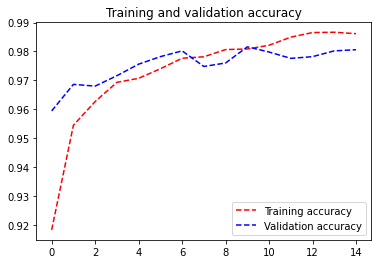

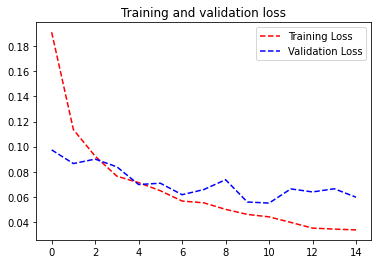

In [46]:
#generate train/validation graph from model history
print('Training/Validation accuracy after Fine Tuning Model')
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r--', label='Training accuracy')
plt.plot(epochs, val_acc, 'b--', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r--', label='Training Loss')
plt.plot(epochs, val_loss, 'b--', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [50]:
#create image names 
images=[str(i)+'.jpg' for i in range(1,12501)]

In [51]:
#make prediction on test images

#bash command change path
%cd '/content/test1/'
results=[]
count=len(images)
for img in images:

    #read image and resize into (150,150,3)
    image=cv2.imread(img)
    resized_image=cv2.resize(image,(150,150))

    #convert image into array and reshape array 
    img_array=np.array(resized_image).reshape(-1,150,150,3)

    #model prediction
    pred=model.predict(img_array)
    results.append(round(pred[0][0]))
    count=count-1
    #print('Image Name {} and predicted class is {}'.format(img,round(pred[0][0])))
    print('Remaining Images {}'.format(count))

Streaming output truncated to the last 5000 lines.
Remaining Images 4998
Remaining Images 4997
Remaining Images 4996
Remaining Images 4995
Remaining Images 4994
Remaining Images 4993
Remaining Images 4992
Remaining Images 4991
Remaining Images 4990
Remaining Images 4989
Remaining Images 4988
Remaining Images 4987
Remaining Images 4986
Remaining Images 4985
Remaining Images 4984
Remaining Images 4983
Remaining Images 4982
Remaining Images 4981
Remaining Images 4980
Remaining Images 4979
Remaining Images 4978
Remaining Images 4977
Remaining Images 4976
Remaining Images 4975
Remaining Images 4974
Remaining Images 4973
Remaining Images 4972
Remaining Images 4971
Remaining Images 4970
Remaining Images 4969
Remaining Images 4968
Remaining Images 4967
Remaining Images 4966
Remaining Images 4965
Remaining Images 4964
Remaining Images 4963
Remaining Images 4962
Remaining Images 4961
Remaining Images 4960
Remaining Images 4959
Remaining Images 4958
Remaining Images 4957
Remaining Images 4956
Rem

In [52]:
%cd '/content'
result_df=pd.DataFrame(results)
result_df.head()
result_df.to_csv('result.csv')

/content


In [53]:
!cp '/content/result.csv' '/content/drive/My Drive/Git repo/Cat vs Dog Classification/'